# Code for First Milestone
## Project: Physical exam findings for DKA patients as a predictor for severity of GCS/cerebral edema.
## Members
- Nate Hayward - Nate.Hayward@hsc.utah.edu - u6031381
- Joshua Kawasaki - J.K.Kawasaki@utah.edu - u1424902
- Andrea Stofko - Andrea.Stofko@utah.edu - u6040357

---------------------------------------------------------------------------------------------------------------------------------------------
## Setup
---------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm

#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

---------------------------------------------------------------------------------------------------------------------------------------------
## Load and Inspect Physical Exam CSV 
---------------------------------------------------------------------------------------------------------------------------------------------

The physical exam file will serve as our primary dataset throughout the analysis. We will use the results found here as predictors of disease progression. The majority of our data cleaning will be focused on the physical exam file.

In [2]:
df_pe_original = pd.read_csv('PHYSEXAM.csv')

df_pe_original.head()

pd.set_option('display.max_columns', None) # View max columns
print(df_pe_original.columns.to_list())

df_pe_original.head()

['PUDID', 'StudyEvent', 'Occurrence', 'ItemGroupRepeatKey', 'PETime', 'PEHEENT', 'PEHEENTDesc', 'PECardio', 'PECardioDesc', 'PEResp', 'PERespDesc', 'PEGI', 'PEGIDesc', 'PEHepatic', 'PEHepaticDesc', 'PEGU', 'PEGUDesc', 'PERenal', 'PERenalDesc', 'PENeuro', 'PENeuroDesc', 'PEPsych', 'PEPsychDesc', 'PEEndo', 'PEEndoDesc', 'PEHema', 'PEHemaDesc', 'PEMusculo', 'PEMusculoDesc', 'PEDerm', 'PEDermDesc', 'PEAllergies', 'PEAllergiesDesc', 'PEImmune', 'PEImmuneDesc', 'PEAlcohol', 'PEAlcoholDesc', 'PEDAY']


,PUDID,StudyEvent,Occurrence,ItemGroupRepeatKey,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY
0,1,Study Initiation,0,0,1750,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0
1,2,Study Initiation,0,0,1145,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0
2,3,Study Initiation,0,0,1240,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0
3,4,Study Initiation,0,0,1354,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0
4,5,Study Initiation,0,0,1432,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0


In [3]:
#Checking - are these all study initiation events? - yes
df_pe_original['StudyEvent'].value_counts() 
df_pe_original['PUDID'].nunique() #1389 - ok, one row per patient
df_pe_original.shape

(1389, 38)

---------------------------------------------------------------------------------------------------------------------------------------------
## Data Cleaning
---------------------------------------------------------------------------------------------------------------------------------------------

In this section, we use one-hot encoding for each part of the physical exam. If any results were marked as 'abnormal' this will be a 1, and 'normal' results will have a 0. Each portion of the exam has a corresponding column for an optional description. Any results that are marked as abnormal will have a description that follows. This will be addressed in the next section of the data cleaning.

In [4]:
def one_hot_encode(df, finding_columns):
    """
    One-hot encodes columns from df. If 'Abnormal', then 1.
    Strips whitespace from original column
    Returns df
    """

    for col in finding_columns:
        class_col = f'{col[2:]}_Class'  # Create class column name (e.g., HEENT_Class)
        df.loc[:, class_col] = df[col].apply(lambda x: 1 if x == 'Abnormal' else 0)
        df[col] = df[col].str.strip()

    return df


df_pe = df_pe_original[['PUDID', 'PETime', 'PEHEENT', 'PEHEENTDesc', 'PECardio', 'PECardioDesc', 
                        'PEResp', 'PERespDesc', 'PEGI', 'PEGIDesc', 'PEHepatic', 'PEHepaticDesc', 
                        'PEGU', 'PEGUDesc', 'PERenal', 'PERenalDesc', 'PENeuro', 'PENeuroDesc', 
                        'PEPsych', 'PEPsychDesc', 'PEEndo', 'PEEndoDesc', 'PEHema', 'PEHemaDesc', 
                        'PEMusculo', 'PEMusculoDesc', 'PEDerm', 'PEDermDesc', 'PEAllergies', 
                        'PEAllergiesDesc', 'PEImmune', 'PEImmuneDesc', 'PEAlcohol', 'PEAlcoholDesc', 
                        'PEDAY']].copy()
finding_columns = [
    'PEHEENT', 'PECardio', 'PEResp', 'PEGI', 'PEHepatic', 'PEGU', 'PERenal', 'PENeuro', 'PEPsych', 'PEEndo', 'PEHema', 'PEMusculo', 
    'PEDerm','PEAllergies', 'PEImmune', 'PEAlcohol']


one_hot_encode(df_pe, finding_columns)

,PUDID,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY,HEENT_Class,Cardio_Class,Resp_Class,GI_Class,Hepatic_Class,GU_Class,Renal_Class,Neuro_Class,Psych_Class,Endo_Class,Hema_Class,Musculo_Class,Derm_Class,Allergies_Class,Immune_Class,Alcohol_Class
0,1,1750,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1145,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0
2,3,1240,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,4,1354,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,5,1432,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,1385,2247,Abnormal,dry mucous membranes,Abnormal,increased heart rate,Abnormal,increased work of breathing,Abnormal,nausea,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,-1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0
1385,1386,1030,Abnormal,lips dry,Abnormal,"capillary refill 3sec, lower extremity cool",Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1386,1387,2110,Abnormal,"decreased moisture in mouth, dry lips, adenopathy",Abnormal,tachycardia,Abnormal,hypopnea,Abnormal,"tenderness over the rectus, abdomen pain (diff...",Normal,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,back pain,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0
1387,1388,1430,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Defining functions to use for cleaning the description columns:

Here we create functions that will utilize regex statements to extract exam descriptions based on key words and phrases specific to each column. These will be used to compile and categorize findings.

In [5]:
# Defining functions for data cleaning
def analyze_term_counts(df, column_name, num_terms=10):
    """
    Prints the top N term counts in a specified column.
    """
    all_terms = df[column_name].str.split(expand=True).stack().str.lower()
    term_counts = all_terms.value_counts()
    for term, count in term_counts.head(num_terms).items():
        print(f"{term}: {count}")

def create_binary_flag(df, description_column, new_column, search_patterns, regex=True):
    """
    Creates a binary flag based on the presence of specified search patterns in the description column.
    regex = False -> treated as literal strings. When regex = True, you can use regex in the search_patterns
    """
    if description_column not in df.columns:
        raise ValueError(f"'{description_column}' not found in {df} columns.")
    if not search_patterns:
        return df

    df[new_column] = 0

    for pattern in search_patterns:
        if regex:
            df.loc[df[description_column].str.contains(pattern, case=False, na=False, regex=True) & (df[new_column] == 0), new_column] = 1
        else:
            df.loc[df[description_column].str.contains(pattern, case=False, na=False, regex=False) & (df[new_column] == 0), new_column] = 1

    return df

def display_abnormal(df, PE_column, desc_column, flag_column):
    """
    Displays rows where it's abnormal, sorted by the flag column.
    """
    pd.set_option('display.max_rows', None) # Displays max rows
    result = df.loc[df[PE_column] == 'Abnormal', [PE_column, desc_column, flag_column]].sort_values(by=flag_column, ascending=True)
    return result
    pd.reset_option('display.max_rows') # Resets to not outputting max rows

In [6]:
# HEENT Dry_MM
#analyze_term_counts(df_pe, 'PEHEENTDesc')

ENT_search = r'(?:dry|muc(?:ous|us)|mm|membrane|tacky)' # Capture dry/tacky mucous membranes
df_pe = create_binary_flag(df_pe, 'PEHEENTDesc', 'HEENT_DryMM', [ENT_search])

#display_abnormal(df_pe, 'PEHEENT', 'PEHEENTDesc', 'HEENT_DryMM')

In [7]:
# Cardio Tachy
#analyze_term_counts(df_pe, 'PECardioDesc')

tachy_search = r'ta(?:(?!pn)\w*ca|\w*chy(?!p)\w*)' # Capture tachycardia
increased_search = r'elevate|increas|raised he|inc[.\w\s]*HR' # Capture elevated heart rate
df_pe = create_binary_flag(df_pe, 'PECardioDesc', 'Cardio_Tachy', [tachy_search, increased_search])

#display_abnormal(df_pe, 'PECardio', 'PECardioDesc', 'Cardio_Tachy')

In [8]:
# Resp Tachy
#analyze_term_counts(df_pe, 'PERespDesc')

# Does not capture Hyperpnea
tachyp_search = r'(?!ta\w*ca)\btac\w*|\bkus\w*|\binc[.\w]+|rapid|fast|raise|\bwob\b' # Captures tachypnea
df_pe = create_binary_flag(df_pe, 'PERespDesc', 'Resp_Tachy', [tachyp_search])

#display_abnormal(df_pe, 'PEResp', 'PERespDesc', 'Resp_Tachy')

In [9]:
# Resp Kuss: Kussmaul breathing pattern on its own
#analyze_term_counts(df_pe, 'PERespDesc')

df_pe = create_binary_flag(df_pe, 'PERespDesc', 'Resp_Kuss', [r'\bkus\w*']) # Kussmaul breathing

#display_abnormal(df_pe, 'PEResp', 'PERespDesc', 'Resp_Kuss')

In [10]:
# GI Tender
#analyze_term_counts(df_pe, 'PEGIDesc')

df_pe = create_binary_flag(df_pe, 'PEGIDesc', 'GI_Tender', [r'tender\w*|TTP']) # Captures tender to palpitation

#display_abnormal(df_pe, 'PEGI', 'PEGIDesc', 'GI_Tender')

In [11]:
#GI - Nausea/Vomiting
#analyze_term_counts(df_pe, 'PEGIDesc')

df_pe = create_binary_flag(df_pe, 'PEGIDesc', 'GI_Vomit', [r'naus\w*|vomit\w*|emesis']) # Captures nausea/vomiting

#display_abnormal(df_pe, 'PEGI', 'PEGIDesc', 'GI_Vomit')

In [12]:
#GU - Polyuria
#analyze_term_counts(df_pe, 'PEGUDesc')

urine_search = r'^(?!.*no\s+urina\w*).*?\b(?:polyuria|increase|freq\w*|urin\w+|pee\w*)\b' # Captures polyuria and excludes not urinating
df_pe = create_binary_flag(df_pe, 'PEGUDesc', 'GU_Urination', [urine_search])

#display_abnormal(df_pe, 'PEGU', 'PEGUDesc', 'GU_Urination')



#Renal - Polyuria
#analyze_term_counts(df_pe, 'PERenalDesc')

df_pe = create_binary_flag(df_pe, 'PERenalDesc', 'GU_Urination', [urine_search]) # Added to same column 'GU_Urination'

#display_abnormal(df_pe, 'PERenal', 'PERenalDesc', 'GU_Urination')

In [13]:
#Neuro - Sleepy/Lethargic/Altered Mental Status/Somnolent/Listless/Fatigued/Tired/Drowsy

#analyze_term_counts(df_pe, 'PENeuroDesc')

sleepy = r'sleep\w*|letharg\w*|confus\w*|som\w+lent|drowsy|tired|fatigu|listless' # Captures fatigue
altered_MS = r'mental status|alter\w*|\bams\b|\bms\b|decreased\s+(?:loa|loc)|\b(?:loa|loc)\b|(?:slow|delay|slur|slug)[\w\s]*(?:respon|speech|answer)|obtun' # Captures altered mental status
GCS_under15 = r'(?:G(?:C|S)|Glasgow\s+coma\s+scale)\s*[\w\s]*[:=-]?\s*(?:[0-9]|1[0-4])' # Less than GCS 15
df_pe = create_binary_flag(df_pe, 'PENeuroDesc', 'Neuro_Sleepy', [sleepy, altered_MS, GCS_under15])

#display_abnormal(df_pe, 'PENeuro', 'PENeuroDesc', 'Neuro_Sleepy')



# PEPsych
df_pe = create_binary_flag(df_pe, 'PEPsychDesc', 'Neuro_Sleepy', [sleepy, altered_MS, GCS_under15]) # Added to same column 'Neuro_Sleepy'

#display_abnormal(df_pe, 'PEPsych', 'PEPsychDesc', 'Neuro_Sleepy')

In [14]:
#Psych - Agitated/Distressed/Irritable
#analyze_term_counts(df_pe, 'PEPsychDesc')

psych_search = r'\bagitat\w+|\bdistres\w+|\birritab\w+' # Captures agitation, distress, and irritability
df_pe = create_binary_flag(df_pe, 'PEPsychDesc', 'Psych_Agitated', [psych_search])

#display_abnormal(df_pe, 'PEPsych', 'PEPsychDesc', 'Psych_Agitated')

In [15]:
#Endo - ketotic breath/acetone breath
#analyze_term_counts(df_pe, 'PEEndoDesc')

endo_search = r'\bbreath\b|\bfruit' # Captures breath with ketotic/acetone breath
df_pe = create_binary_flag(df_pe, 'PEEndoDesc', 'Endo_Breath', [endo_search])

#display_abnormal(df_pe, 'PEEndo', 'PEEndoDesc', 'Endo_Breath')

In [16]:
#MSK - Thin - 'Cachectic'- 'Thin-appearing' 'Thin extremities' etc. 
#analyze_term_counts(df_pe, 'PEMusculoDesc')

cachectic_search = r'\bthin|\bcache\w*|\bskinny|atrophy|\bwast\w+' # Captures thin physical appearance
df_pe = create_binary_flag(df_pe, 'PEMusculoDesc', 'MSK_Thin', [cachectic_search])

#display_abnormal(df_pe, 'PEMusculo', 'PEMusculoDesc', 'MSK_Thin')

In [17]:
#MSK - Muscle Pain - 'Myalgia' 'Muscle Pain'
#analyze_term_counts(df_pe, 'PEMusculoDesc')

pain_search = r'\bpain|\bmyalgia|ach(?:e|i)\w*' # Captures musculoskeletal pain
df_pe = create_binary_flag(df_pe, 'PEMusculoDesc', 'MSK_Pain', [pain_search])

#display_abnormal(df_pe, 'PEMusculo', 'PEMusculoDesc', 'MSK_Pain')

In [18]:
# DERM - Pallor/Pale skin
# May be discriminatory for patients with darker skin?

#analyze_term_counts(df_pe, 'PEDermDesc')

pale_search = r'\bpal(?:e|lor|lid)' # Captures pale skin
df_pe = create_binary_flag(df_pe, 'PEDermDesc', 'Derm_Pale', [pale_search])

#display_abnormal(df_pe, 'PEDerm', 'PEDermDesc', 'Derm_Pale')

In [19]:
# DERM - Dry skin
#analyze_term_counts(df_pe, 'PEDermDesc')

dry_search = r'\bdry|\bdried' # Captures dry skin
df_pe = create_binary_flag(df_pe, 'PEDermDesc', 'Derm_DrySkin', [dry_search])

#display_abnormal(df_pe, 'PEDerm', 'PEDermDesc', 'Derm_DrySkin')

In [20]:
df_pe.head(10)

,PUDID,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY,HEENT_Class,Cardio_Class,Resp_Class,GI_Class,Hepatic_Class,GU_Class,Renal_Class,Neuro_Class,Psych_Class,Endo_Class,Hema_Class,Musculo_Class,Derm_Class,Allergies_Class,Immune_Class,Alcohol_Class,HEENT_DryMM,Cardio_Tachy,Resp_Tachy,Resp_Kuss,GI_Tender,GI_Vomit,GU_Urination,Neuro_Sleepy,Psych_Agitated,Endo_Breath,MSK_Thin,MSK_Pain,Derm_Pale,Derm_DrySkin
0,1,1750,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1145,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0
2,3,1240,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0
3,4,1354,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1432,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
5,6,1029,Normal,NaN,Abnormal,Tachycardic,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,7,1216,Normal,NaN,Abnormal,tachycardic,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,pale,Not Assessed,NaN,Abnormal,pale,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
7,8,1855,Abnormal,dry mucosa,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8,9,1855,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Mild diffuse abdominal tenderness,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,"Polydypsia, Polyphagia",Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9,10,2140,Abnormal,"dry mucous membranes, injection eyes",Abnormal,"tachychardic, per triage note: cap refill less...",Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,concern for DKA,Normal,NaN,Normal,NaN,Abnormal,dry,Normal,NaN,Normal,NaN,Normal,NaN,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1


### Converting Physical Exam Time to a DateTime data type

In order to compare time between the physical exam and the imaging time, both of these columns will be converted from an int to a datetime in each of the datasets.

In [21]:
#converting PETime to datetime

#first convert to string for date time function
df_pe['PETime'] = (df_pe['PETime']).astype(str)

#some values are single digits - assuming there are leading zeros
df_pe.loc[df_pe["PETime"] == "0", "PETime"] = "0000"
df_pe.loc[df_pe["PETime"] == "1", "PETime"] = "0001"
df_pe.loc[df_pe["PETime"] == "2", "PETime"] = "0002"
df_pe.loc[df_pe["PETime"] == "4", "PETime"] = "0004"
df_pe.loc[df_pe["PETime"] == "9", "PETime"] = "0009"

#convert to time
df_pe['PETime'] = pd.to_datetime(df_pe['PETime'], format='%H%M').dt.time# Print the DataFrameprint(df)
df_pe.head()

,PUDID,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY,HEENT_Class,Cardio_Class,Resp_Class,GI_Class,Hepatic_Class,GU_Class,Renal_Class,Neuro_Class,Psych_Class,Endo_Class,Hema_Class,Musculo_Class,Derm_Class,Allergies_Class,Immune_Class,Alcohol_Class,HEENT_DryMM,Cardio_Tachy,Resp_Tachy,Resp_Kuss,GI_Tender,GI_Vomit,GU_Urination,Neuro_Sleepy,Psych_Agitated,Endo_Breath,MSK_Thin,MSK_Pain,Derm_Pale,Derm_DrySkin
0,1,17:50:00,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,11:45:00,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0
2,3,12:40:00,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0
3,4,13:54:00,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,14:32:00,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


## Importing Imaging Data CSV

We will clean the imaging csv and merge it into the main physical exam dataframe using the patient identifier (PUDID).

In [22]:
#load in imaging data
imaging = pd.read_csv("IMAGING.csv")
imaging.head()

,PUDID,StudyEvent,Occurrence,ItemGroupRepeatKey,ImageTime,ImageType,IMAGEDAY
0,13,DKA Treatment,0,1,2207,CT,0
1,17,DKA Treatment,0,1,29,CT,1
2,40,DKA Treatment,0,1,1615,CT,0
3,42,DKA Treatment,0,1,101,CT,1
4,43,DKA Treatment,0,1,1315,CT,0


### Converting imaging time to a %H%M datetime data type

In [23]:
#change time to datetime
imaging['ImageTime'] = imaging['ImageTime'].astype(str).str.zfill(4) #add leading zeros where time is less than 4 digits
#convert to time
imaging['ImageTime'] = pd.to_datetime(imaging['ImageTime'], format='%H%M').dt.time # Print the DataFrameprint(df)

### Merging cleaned imaging dataset into the main physical exam dataset on PUDID

In [24]:
#merge dataframes
df_pe_imaging = pd.merge(df_pe, imaging, how ='outer', on ='PUDID') 

#drop extra columns
df_pe_imaging.drop(['StudyEvent','Occurrence', 'ItemGroupRepeatKey'], axis = 1)
df_pe_imaging.head()
#df_pe_imaging.shape #there are some patients with multiple imaging times

,PUDID,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY,HEENT_Class,Cardio_Class,Resp_Class,GI_Class,Hepatic_Class,GU_Class,Renal_Class,Neuro_Class,Psych_Class,Endo_Class,Hema_Class,Musculo_Class,Derm_Class,Allergies_Class,Immune_Class,Alcohol_Class,HEENT_DryMM,Cardio_Tachy,Resp_Tachy,Resp_Kuss,GI_Tender,GI_Vomit,GU_Urination,Neuro_Sleepy,Psych_Agitated,Endo_Breath,MSK_Thin,MSK_Pain,Derm_Pale,Derm_DrySkin,StudyEvent,Occurrence,ItemGroupRepeatKey,ImageTime,ImageType,IMAGEDAY
0,1,17:50:00,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11:45:00,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,12:40:00,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,13:54:00,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,14:32:00,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### Converting imaging times to actual date times based on IMAGEDAY and PEDAY

Rather than providing the actual date, each patient observation for both the physical exam and imaging dataset contains a PEDAY (Physical Exam Day) and ImageDay column which is in reference to the admission date. For instance, if the physical exam took place on the day of the admission, the PEDAY column would be 0. If the imaging took place the next day, the ImageDay would be 1. Therefore, arbitrary dates were selected as a reference date for the admission that would allow us to effectively compare the time between events.

In [25]:
#creating reference date - change if there is a real reference date for each patient visit

df_pe_imaging["ImageTime"] = df_pe_imaging["ImageTime"].astype(str)
df_pe_imaging["PETime"] = df_pe_imaging["PETime"].astype(str)

# Convert ImageTime to timedelta
df_pe_imaging["ImageTime"] = pd.to_timedelta(df_pe_imaging["ImageTime"])
df_pe_imaging["PETime"] = pd.to_timedelta(df_pe_imaging["PETime"])

# Set reference date
reference_date = pd.to_datetime("2025-01-01")

# Compute full datetime
df_pe_imaging["ImagingDateTime"] = reference_date + pd.to_timedelta(df_pe_imaging["IMAGEDAY"], unit="D") + df_pe_imaging["ImageTime"]
df_pe_imaging["ExamDateTime"] = reference_date + pd.to_timedelta(df_pe_imaging["PEDAY"], unit="D") + df_pe_imaging["PETime"]

df_pe_imaging.head()

,PUDID,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY,HEENT_Class,Cardio_Class,Resp_Class,GI_Class,Hepatic_Class,GU_Class,Renal_Class,Neuro_Class,Psych_Class,Endo_Class,Hema_Class,Musculo_Class,Derm_Class,Allergies_Class,Immune_Class,Alcohol_Class,HEENT_DryMM,Cardio_Tachy,Resp_Tachy,Resp_Kuss,GI_Tender,GI_Vomit,GU_Urination,Neuro_Sleepy,Psych_Agitated,Endo_Breath,MSK_Thin,MSK_Pain,Derm_Pale,Derm_DrySkin,StudyEvent,Occurrence,ItemGroupRepeatKey,ImageTime,ImageType,IMAGEDAY,ImagingDateTime,ExamDateTime
0,1,0 days 17:50:00,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 17:50:00
1,2,0 days 11:45:00,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 11:45:00
2,3,0 days 12:40:00,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 12:40:00
3,4,0 days 13:54:00,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 13:54:00
4,5,0 days 14:32:00,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 14:32:00


### Create column to capture the total number of abnormal test results:

In [26]:
df_pe_imaging['exam_total'] = df_pe_imaging['HEENT_DryMM']+ df_pe_imaging['Cardio_Tachy'] + df_pe_imaging['Resp_Tachy'] +df_pe_imaging['Resp_Kuss'] + df_pe_imaging['GI_Tender'] + df_pe_imaging['GI_Vomit'] + df_pe_imaging['GU_Urination'] + df_pe_imaging['Neuro_Sleepy'] + df_pe_imaging['Psych_Agitated'] + df_pe_imaging['Endo_Breath'] + df_pe_imaging['MSK_Thin'] +df_pe_imaging['MSK_Pain'] +df_pe_imaging['Derm_Pale'] + df_pe_imaging['Derm_DrySkin']
df_pe_imaging.head()


,PUDID,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY,HEENT_Class,Cardio_Class,Resp_Class,GI_Class,Hepatic_Class,GU_Class,Renal_Class,Neuro_Class,Psych_Class,Endo_Class,Hema_Class,Musculo_Class,Derm_Class,Allergies_Class,Immune_Class,Alcohol_Class,HEENT_DryMM,Cardio_Tachy,Resp_Tachy,Resp_Kuss,GI_Tender,GI_Vomit,GU_Urination,Neuro_Sleepy,Psych_Agitated,Endo_Breath,MSK_Thin,MSK_Pain,Derm_Pale,Derm_DrySkin,StudyEvent,Occurrence,ItemGroupRepeatKey,ImageTime,ImageType,IMAGEDAY,ImagingDateTime,ExamDateTime,exam_total
0,1,0 days 17:50:00,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 17:50:00,0
1,2,0 days 11:45:00,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 11:45:00,3
2,3,0 days 12:40:00,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 12:40:00,4
3,4,0 days 13:54:00,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 13:54:00,1
4,5,0 days 14:32:00,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 14:32:00,2


## Importing Demographics Data

**Using the Codebook, variables are assigned as follows:**
* Sex = Sex
* Ethnicity = Ethnicity 
* Race 1 = American Indian or Alaska Native 
* Race 2 = Asian
* Race 3 = Black or African American
* Race 3 = Native Hawaiian or Other Pacific Islander 
* Race 5 = White
* Race 92 = Unknown or Not Reported
* AgeInYears = Age in years

### Load demographics and inspect dataframe:

Here each of the columns are coded according to how they are defined in the study codebook. Summary statistics were created for sex, ethnicity, race and age using the value_counts() and describe() functions.

In [27]:
df_demo = pd.read_csv('Demographics.csv')

df_demo = df_demo[['PUDID', 'Sex', 'Ethnicity', 'Race1', 'Race2', 'Race3', 'Race4', 'Race5', 'Race92', 'AgeInYears']]

#Rename the columns 
df_demo = df_demo.rename(columns={
    'Race1': 'American Indian or Alaska Native',
    'Race2': 'Asian',
    'Race3': 'Black or African American',
    'Race4': 'Native Hawaiian or Other Pacific Islander',
    'Race5': 'White',
    'Race92': 'Unknown or Not Reported',
    'AgeInYears': 'Age'
})

#Total number of patients
total = len(df_demo['PUDID'])
print("Total number of patients:", total)

# Create a dictionary to store value counts for each category
summary_data = {
    'Sex': df_demo['Sex'].value_counts(),
    'Ethnicity': df_demo['Ethnicity'].value_counts(),
    'American Indian or Alaska Native': df_demo['American Indian or Alaska Native'].value_counts(), 
    'Asian': df_demo['Asian'].value_counts(),
    'Black or African American': df_demo['Black or African American'].value_counts(),
    'Native Hawaiian or Other Pacific Islander': df_demo['Native Hawaiian or Other Pacific Islander'].value_counts(),
    'White': df_demo['White'].value_counts(),
    'Unknown or Not Reported': df_demo['Unknown or Not Reported'].value_counts(),
}

#Convert dictionary to DataFrame
summary_df = pd.DataFrame(summary_data)

# Display the summary table
print(summary_df)

df_demo['Age'].describe(percentiles = [.25, .5, .75])

Total number of patients: 1389
                          Sex  Ethnicity  American Indian or Alaska Native  \
Female                  739.0        NaN                               NaN   
Hispanic or Latino        NaN      228.0                               NaN   
Male                    650.0        NaN                               NaN   
No                        NaN        NaN                            1369.0   
Not Hispanic or Latino    NaN     1109.0                               NaN   
Unknown                   NaN       52.0                               NaN   
Yes                       NaN        NaN                              20.0   

                         Asian  Black or African American  \
Female                     NaN                        NaN   
Hispanic or Latino         NaN                        NaN   
Male                       NaN                        NaN   
No                      1374.0                     1063.0   
Not Hispanic or Latino     NaN         

count    1389.000000
mean       11.607329
std         4.072595
min         0.536986
25%         9.224216
50%        12.221918
75%        14.632877
max        17.994521
Name: Age, dtype: float64

### Additional cleaning of demographics data:

For each of the race columns, the values "Yes"/"No" are replaced with 1s and 0s to simplify creating bar charts for counts.

In [28]:
#Changing Race to 1/0s for easier plotting
df_demo[['American Indian or Alaska Native', 'Asian', 'Black or African American', 'Native Hawaiian or Other Pacific Islander',
'White','Unknown or Not Reported']] = (df_demo[['American Indian or Alaska Native', 'Asian', 'Black or African American', 'Native Hawaiian or Other Pacific Islander',
'White','Unknown or Not Reported']]).replace({"Yes":1, "No":0})
df_demo.head()

C:\Users\joshu\AppData\Local\Temp\ipykernel_27668\3686076929.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  'White','Unknown or Not Reported']]).replace({"Yes":1, "No":0})


,PUDID,Sex,Ethnicity,American Indian or Alaska Native,Asian,Black or African American,Native Hawaiian or Other Pacific Islander,White,Unknown or Not Reported,Age
0,1,Male,Hispanic or Latino,0,0,0,0,1,0,10.621918
1,2,Male,Hispanic or Latino,0,0,1,0,0,0,17.479452
2,3,Male,Not Hispanic or Latino,0,0,0,0,1,0,16.438162
3,4,Male,Not Hispanic or Latino,0,0,0,0,1,0,13.194521
4,5,Male,Hispanic or Latino,0,0,0,0,1,0,12.073770


---------------------------------------------------------------------------------------------------------------------------------------------
## Exploratory Analysis
---------------------------------------------------------------------------------------------------------------------------------------------

#### Histogram of Patient Age:

In [29]:
#import matplot lib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

<Figure size 1000x600 with 0 Axes>

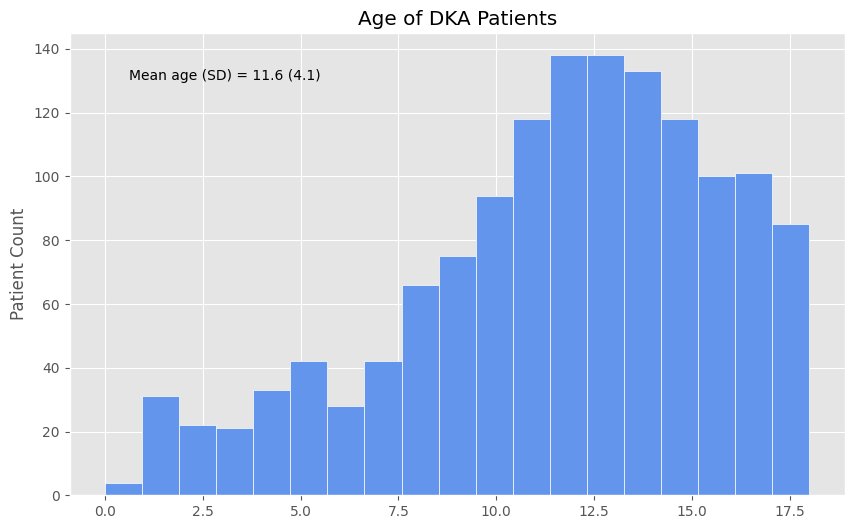

In [30]:
#histogram for age
fig = plt.figure(figsize = (10,6))

fig, ax = plt.subplots()
ax.hist(df_demo['Age'],
        bins = 19,
        range = (0,18),
                color = 'cornflowerblue',
       edgecolor = 'white') 
ax.set_title("Age of DKA Patients")
ax.set_ylabel("Patient Count")
ax.text(0.2, 0.9, "Mean age (SD) = 11.6 (4.1)", fontsize=10, ha="center", transform=ax.transAxes)

plt.show()

#### Showing distribution of patient races using a barchart:

(A more condensed Table 1 was used for the First Milestone document)

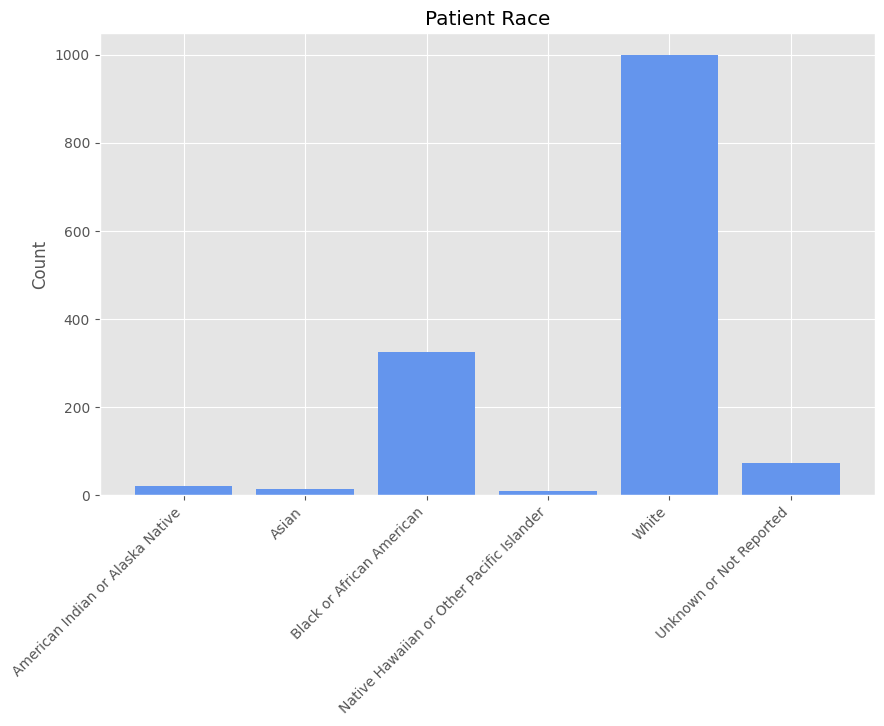

In [31]:
#create race counts

#subset dataframe for just race columns
race_counts = df_demo[['American Indian or Alaska Native', 'Asian', 'Black or African American', 'Native Hawaiian or Other Pacific Islander',
'White','Unknown or Not Reported']].sum()

fig, ax = plt.subplots(figsize = (10,6))
ax.bar(race_counts.index, race_counts.values,
                color = 'cornflowerblue')
       
ax.set_title("Patient Race")
ax.set_ylabel("Count")
plt.xticks(rotation = 45, ha = 'right')

plt.show()

### Looking at distribution of total number of abnormal results (exam_total)

<Figure size 1000x600 with 0 Axes>

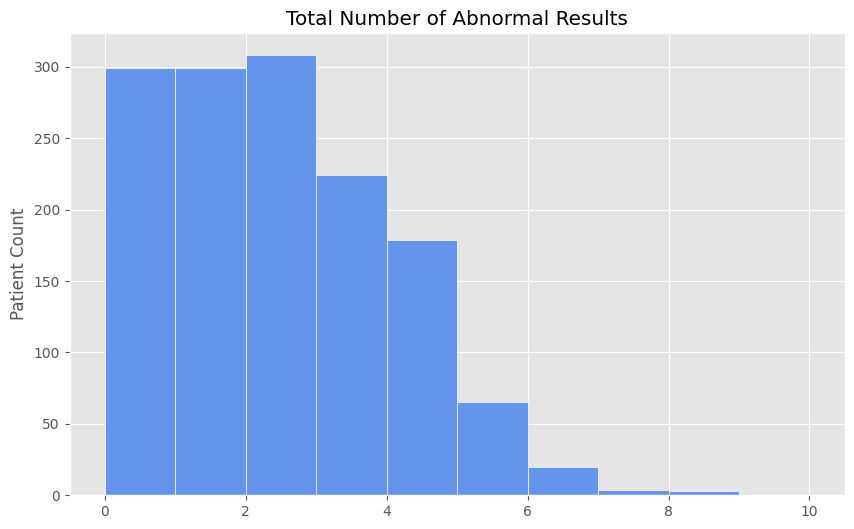

In [32]:
#histogram for exam totals
fig = plt.figure(figsize = (10,6))

fig, ax = plt.subplots()
ax.hist(df_pe_imaging['exam_total'],
        bins = 10,
        range = (0,10),
                color = 'cornflowerblue',
       edgecolor = 'white') 
ax.set_title("Total Number of Abnormal Results")
ax.set_ylabel("Patient Count")


plt.show()